# SEC Disclosures Scaper
Setup webscraping to scrape SEC financial reports (ex. [APPL](https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000032019321000105/aapl-20210925.htm)) for diversity and inclusion statements.

##### Data Sources
* SEC Master index of filings (ex. Q1 2021: https://www.sec.gov/Archives/edgar/full-index/2021/QTR1/master.idx)
* SEC text archives (ex. AAPL 2021 10-K: https://www.sec.gov/Archives/edgar/data/0000320193/0000320193-21-000105.txt)

##### Notes
* If a user or application submits more than 10 requests per second, further requests from the IP address(es) may be limited for a brief period. Once the rate of requests has dropped below the threshold for 10 minutes, the user may resume accessing content on SEC.gov. This SEC practice is designed to limit excessive automated searches on SEC.gov and is not intended or expected to impact individuals browsing the SEC.gov website.

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import json
import pprint
import pandas as pd
import time

# fix ssl certificate (needed for MacOS sometimes)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Step 1: Get List All 10-Q Links for Companies in 2021
* Using edgar master index endpoint, retrieve list of all filed 10-Q's for the 2021 year
* Organize data in a pandas dataframe

In [2]:
# prepare headers to give us permission to access html content
headers = {"User-agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"}

# set up variables in scrape 10-Q links for all four quarters in 2021
tenKs = []
year = 2021
quarters = [1,2,3,4]
for quarter in quarters:
    r = requests.get(f'https://www.sec.gov/Archives/edgar/full-index/{year}/QTR{quarter}/master.idx', headers=headers).content
    r = r.decode("utf-8").split('\n')
    tenKs.extend([row for row in r if '10-K' in row])

In [3]:
df = pd.DataFrame([row.split('|') for row in tenKs])
df.columns = ['cik', 'companyName', 'filingType', 'date', 'link']
df['cik'] = df['cik'].astype(int)
df.head(10)

,cik,companyName,filingType,date,link
0,1000209,MEDALLION FINANCIAL CORP,10-K,2021-03-16,edgar/data/1000209/0001564590-21-013216.txt
1,1000228,HENRY SCHEIN INC,10-K,2021-02-17,edgar/data/1000228/0001000228-21-000019.txt
2,1000229,CORE LABORATORIES N V,10-K,2021-02-08,edgar/data/1000229/0001564590-21-004561.txt
3,1000232,KENTUCKY BANCSHARES INC /KY/,10-K,2021-03-03,edgar/data/1000232/0001558370-21-002326.txt
4,1000298,IMPAC MORTGAGE HOLDINGS INC,10-K,2021-03-12,edgar/data/1000298/0001558370-21-002945.txt
5,1000623,SCHWEITZER MAUDUIT INTERNATIONAL INC,10-K,2021-03-01,edgar/data/1000623/0001000623-21-000047.txt
6,1000683,BLONDER TONGUE LABORATORIES INC,10-K,2021-03-25,edgar/data/1000683/0001213900-21-017745.txt
7,1000694,NOVAVAX INC,10-K,2021-03-01,edgar/data/1000694/0001000694-21-000004.txt
8,1000697,WATERS CORP /DE/,10-K,2021-02-24,edgar/data/1000697/0001193125-21-054385.txt
9,1000753,"INSPERITY, INC.",10-K,2021-02-12,edgar/data/1000753/0001000753-21-000009.txt


## Step 2: Merge with our CIK List
Grab the links for the CIKs that we care about.

In [4]:
# ciks = [1326801, 320193, 1321655, 1065280, 1800]     # sample list of ciks (FB, AAPL, PLTR, NFLX, ABT)
# ciks = [320193, 1800]
# df_ciks = pd.DataFrame(ciks) # convert to df
# df_ciks.columns = ['cik']
# df_ciks

In [5]:
df_prod = pd.read_stata('../data/productivity.dta')
df_prod['cik'] = df_prod['cik'].astype(int)
# df_prod.sort_values('cik').head(20)
# df_prod = df_prod.drop_duplicates(subset='cik', keep="first")

# left merge with original df
df_prod = df_prod.merge(df, on='cik') #[df['filingType']=='10-K']
df_prod = df_prod.sort_values(['cik', 'filingType']).drop_duplicates(subset='cik', keep="first")
df_prod

,cik,fpe,prod,companyName,filingType,date,link
0,1800,21914.0,5.716526,ABBOTT LABORATORIES,10-K,2021-02-19,edgar/data/1800/0001104659-21-025751.txt
2,2098,21914.0,5.784577,ACME UNITED CORP,10-K,2021-03-31,edgar/data/2098/0001564590-21-017128.txt
6,2178,21914.0,7.882299,"ADAMS RESOURCES & ENERGY, INC.",10-K,2021-03-05,edgar/data/2178/0000002178-21-000034.txt
8,2488,21914.0,6.439573,ADVANCED MICRO DEVICES INC,10-K,2021-01-29,edgar/data/2488/0001628280-21-001185.txt
10,3197,21914.0,6.038995,CECO ENVIRONMENTAL CORP,10-K,2021-03-03,edgar/data/3197/0001564590-21-010416.txt
...,...,...,...,...,...,...,...
4642,1792580,21914.0,7.973031,Ovintiv Inc.,10-K,2021-02-18,edgar/data/1792580/0001564590-21-006570.txt
4644,1808834,21914.0,5.800146,"PROG Holdings, Inc.",10-K,2021-02-26,edgar/data/1808834/0001808834-21-000012.txt
4648,1811074,21914.0,8.690374,Texas Pacific Land Corp,10-K,2021-02-25,edgar/data/1811074/0001811074-21-000013.txt
4787,1823608,22280.0,6.399959,Amalgamated Financial Corp.,10-K,2021-03-15,edgar/data/1823608/0001823608-21-000010.txt


## Step 3: Scrape 10-K and Store
* for each cik, scrape the text of its 10-K, pick out instances of the word 'diversity'
* store scrapes in json file

In [6]:
def scrape_10k(link):
    # scrape text
    url = f'https://www.sec.gov/Archives/{link}'
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

def get_header_style_attr(s):
    if s.get('style'):
        style_attr = s.get('style').split(';') # get all attributes that appear in the style string
        return [style for style in style_attr if 'font' in style] # filter to only get font attributes
    return []

def get_human_capital_section(soup):
    is_human_capital = False
    header_style = ''
    header_style_attr = []
    tag_type = 'span'
    human_capital_text = []
    tags_to_try = ['div', 'span', 'p']
    for tag in tags_to_try:
        for s in soup.find_all(tag):
            # looking for section with 'human capital' in header
            if not is_human_capital and 'human capital' in s.text.lower() and len(s.text) <= 100:
                header_style = s.get('style') # found human capital section, remember 'style' so that we know when the next section appears
                header_style_attr = get_header_style_attr(s)
                is_human_capital = True       # set indicator variable to True
                human_capital_text.append(s.text)

            # add text found in human capital section
            elif is_human_capital and get_header_style_attr(s) != header_style_attr: #s.get('style') != header_style:
                human_capital_text.append(s.text)

            # new section is starting, stop adding text
            else:
                is_human_capital = False
    
    return human_capital_text

test solution

In [7]:
link = 'edgar/data/1168054/0001168054-21-000008.txt'
soup = scrape_10k(link)

In [8]:
get_human_capital_section(soup)

['Human Capital Resources',
 'Human Capital Resources',
 '',
 'As of December\xa031, 2020, Cimarex employed 747 highly talented and committed individuals across our field operations and business offices.  Our employee base was reduced in 2020 by approximately 24% from December 31, 2019 as a result of a voluntary early retirement incentive program we offered to employees who met certain eligibility criteria in the first quarter of 2020 and an involuntary reduction in workforce program we carried out in the third quarter of 2020.  These programs were initiated to ensure the size of our workforce is consistent with our expected future activity levels. ',
 '',
 '',
 '17',
 'Table of Contents',
 '',
 'Fostering a healthy culture built upon transparency, trust, collaboration, and results is an area of emphasis for Cimarex leadership.  Key areas of Cimarex Human Capital focus are:',
 '',
 'Health and Safety',
 '',
 'The health and safety of every Cimarex employee is our top priority.  In 2020

In [9]:
link = 'edgar/data/1168054/0001168054-21-000008.txt'
link.find('edgar/data/') + len('edgar/data/')

11

In [10]:
link.split('/')[2]

'1168054'

In [11]:
# get 10 random links
links = df_prod.sample(5, random_state=123)['link'].tolist()
pprint.pprint(links)

# scrape human capital disclosure for each link, store it
hc_disc = {}
for link in links:
    cik = link.split('/')[2]
    print(cik)
    hc_disc[cik] = get_human_capital_section(scrape_10k(link))

['edgar/data/744218/0001104659-21-043161.txt',
 'edgar/data/1168054/0001168054-21-000008.txt',
 'edgar/data/1667161/0001564590-21-012544.txt',
 'edgar/data/7084/0000007084-21-000008.txt',
 'edgar/data/1637761/0001637761-21-000056.txt']
744218
1168054
1667161
7084
1637761


In [12]:
for key, val in hc_disc.items():
    print(key)
    pprint.pprint(val)
    print('\n\n')

744218
[]



1168054
['Human Capital Resources',
 'Human Capital Resources',
 '',
 'As of December\xa031, 2020, Cimarex employed 747 highly talented and '
 'committed individuals across our field operations and business offices.  Our '
 'employee base was reduced in 2020 by approximately 24% from December 31, '
 '2019 as a result of a voluntary early retirement incentive program we '
 'offered to employees who met certain eligibility criteria in the first '
 'quarter of 2020 and an involuntary reduction in workforce program we carried '
 'out in the third quarter of 2020.  These programs were initiated to ensure '
 'the size of our workforce is consistent with our expected future activity '
 'levels. ',
 '',
 '',
 '17',
 'Table of Contents',
 '',
 'Fostering a healthy culture built upon transparency, trust, collaboration, '
 'and results is an area of emphasis for Cimarex leadership.  Key areas of '
 'Cimarex Human Capital focus are:',
 '',
 'Health and Safety',
 '',
 'The health and s

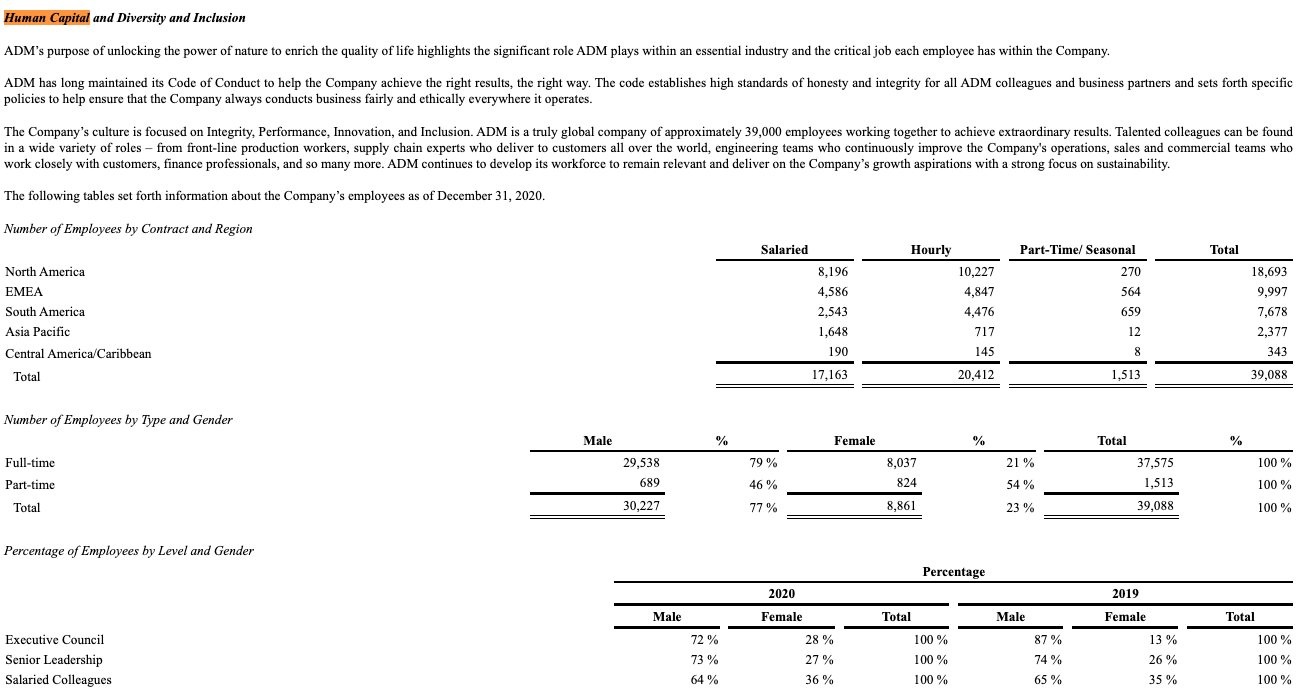

In [30]:
#print(hc_disc)
# Need to get rid of values of []
# Need to get rid of any values of [] that have empty string '-'
# and possibly '-'

new_hc_disc = {}
new_val = []
for key, val in hc_disc.items():
    if key not in new_hc_disc:
        
        #new_val = []
        if [] == val:
            new_hc_disc[key] = 'There is no Human Capital Disclosure'
            #hc_disc[key] = 'There is no Human Capital Disclosure'
#         elif ' -' in val:
#             val.remove(' -')
        else:
            #pprint.pprint(val)
            for element in val:
                #new_val = []
                if element.strip(' -'):
                    new_val.append(element)    
                    #val.remove(element)
                else:
                    continue
            new_hc_disc[key] = new_val
            #hc_disc[key] = val
            
    else:
        continue


#print(hc_disc)
#pprint.pprint(new_val)
pprint.pprint(new_hc_disc)
#print(new_hc_disc)
#print(new_val)
#print(val)
#print(type(new_val))
#print(len(val))

{'1168054': ['Human Capital Resources',
             'Human Capital Resources',
             'As of December\xa031, 2020, Cimarex employed 747 highly talented '
             'and committed individuals across our field operations and '
             'business offices.  Our employee base was reduced in 2020 by '
             'approximately 24% from December 31, 2019 as a result of a '
             'voluntary early retirement incentive program we offered to '
             'employees who met certain eligibility criteria in the first '
             'quarter of 2020 and an involuntary reduction in workforce '
             'program we carried out in the third quarter of 2020.  These '
             'programs were initiated to ensure the size of our workforce is '
             'consistent with our expected future activity levels. ',
             '17',
             'Table of Contents',
             'Fostering a healthy culture built upon transparency, trust, '
             'collaboration, and res

In [ ]:
soup1 = scrape_10k('edgar/data/744218/0001104659-21-043161.txt')

In [ ]:
for s in soup1.find_all('span'):
    if 'human capital' in s.text.lower():
        print(s)

In [ ]:
len(scrape_10k('edgar/data/1442145/0001437749-21-003789.txt').find_all('p'))

In [ ]:
# scrape text
url = 'https://www.sec.gov/Archives/edgar/data/1800/0001104659-21-025751.txt'
r = requests.get(url, headers=headers)
soup = BeautifulSoup(r.text, 'html.parser')

In [ ]:
hc = get_human_capital_section(soup4)
hc

In [ ]:
# convert to dict
files = df.to_dict(orient='records')

# loop through each file, download file from internet
# download 10 files, wait 1 second...SEC limits the number of api calls we can make per second
count = 0
for file in files:
    print(file['companyName'])
    
    # scrape text
    url = f'https://www.sec.gov/Archives/{file["link"]}'
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')

    # get all text
    text_all = []
    for div in soup.find_all('div'):
        text_block = ''
        for span in div.find_all('span'):
            text_block += span.text
        text_all.append(text_block)

    # get text mentioning diversity
    text_diversity = [text for text in text_all if 'diversity' in text.lower()]
    
    # store in dict
    file['textAll'] = text_all
    file['textDiversity'] = text_diversity
    
    print(str(len(text_diversity)) + ' mentions of diversity found')
    print()
    
    # update counter
    count += 1
    if count == 10:
        count = 0
        time.sleep(1)

In [ ]:
with open('../data/filings2021.json', 'w') as f:
    json.dump(files, f)

## View Results of Scraping

In [ ]:
# for file in files:
#     print(file['companyName'])
#     pprint.pprint(file['textDiversity'])
#     print()

In [ ]:
url = 'https://www.sec.gov/Archives/edgar/data/1800/0001104659-21-025751.txt'
r = requests.get(url, headers=headers)
soup = BeautifulSoup(r.text, 'html.parser')

In [ ]:
for s in soup.find_all('p'):
    if 'diversity' in s.text.lower():
        print(s.text)

In [ ]:
df_prod = pd.read_stata('../data/productivity.dta')
# df_prod['cik'] = df_prod['cik'].astype(int)
df_prod.sort_values('cik').head(20)

In [ ]:
len(df_prod['cik'].unique())

In [ ]:
# left merge with original df
df_prod = df_prod.merge(df, on='cik')
df_prod

In [ ]:
df.info()

In [ ]:
df_prod.merge(df[df['filingType']=='10-K'], on='cik')

In [ ]:
df_prod[df_prod['cik']==1800]